<a href="https://colab.research.google.com/github/jijan67/Multi-Weather-Classification-Using-Transfer-Learning/blob/main/Multi_Weather_Classification_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

In [ ]:
# Load data
data_dir = '/content/drive/MyDrive/MultiWeatherDataset'


In [ ]:
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    pics = os.listdir(foldpath)
    for pic in pics:
        pic_path = os.path.join(foldpath, pic)
        filepaths.append(pic_path)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='Pic Path')
LSeries = pd.Series(labels, name='Labels')

df = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Labels'])


In [ ]:
# Initialize VGG19 model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to extract features using VGG19
def extract_features_vgg(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = vgg_model.predict(img_array)
    return features.flatten()  # Flatten the feature tensor to use it as input for logistic regression


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# Extract features for train and test sets
X_train = np.array([extract_features_vgg(img_path) for img_path in train_df['Pic Path']])
X_test = np.array([extract_features_vgg(img_path) for img_path in test_df['Pic Path']])
y_train = train_df['Labels']
y_test = test_df['Labels']

1/1 [==============================] - 0s 21ms/step


In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Fit the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
# Predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [ ]:
# Train, test, and validation accuracy and loss
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)

train_loss = classification_report(y_train, y_pred_train, output_dict=True)['accuracy']
test_loss = classification_report(y_test, y_pred_test, output_dict=True)['accuracy']
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

print(f"Training Loss: {train_loss}")
print(f"Test Loss: {test_loss}")


Training Accuracy: 0.9993593850096092
Test Accuracy: 0.9181585677749361
Training Loss: 0.9993593850096092
Test Loss: 0.9181585677749361


In [ ]:
# Evaluate the model
print("Training Classification Report:")
print(classification_report(y_train, y_pred_train))
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))


Training Classification Report:
              precision    recall  f1-score   support

      Cloudy       1.00      1.00      1.00       240
         Fog       1.00      1.00      1.00       240
        Rain       1.00      1.00      1.00       172
        Sand       1.00      1.00      1.00       258
       Shine       1.00      1.00      1.00       202
        Snow       1.00      1.00      1.00       163
     Sunrise       1.00      1.00      1.00       286

    accuracy                           1.00      1561
   macro avg       1.00      1.00      1.00      1561
weighted avg       1.00      1.00      1.00      1561

Test Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.93      0.93      0.93        60
         Fog       0.83      0.83      0.83        60
        Rain       1.00      0.98      0.99        43
        Sand       0.89      0.86      0.88        65
       Shine       0.98      0.88      0.93        51
        Snow      

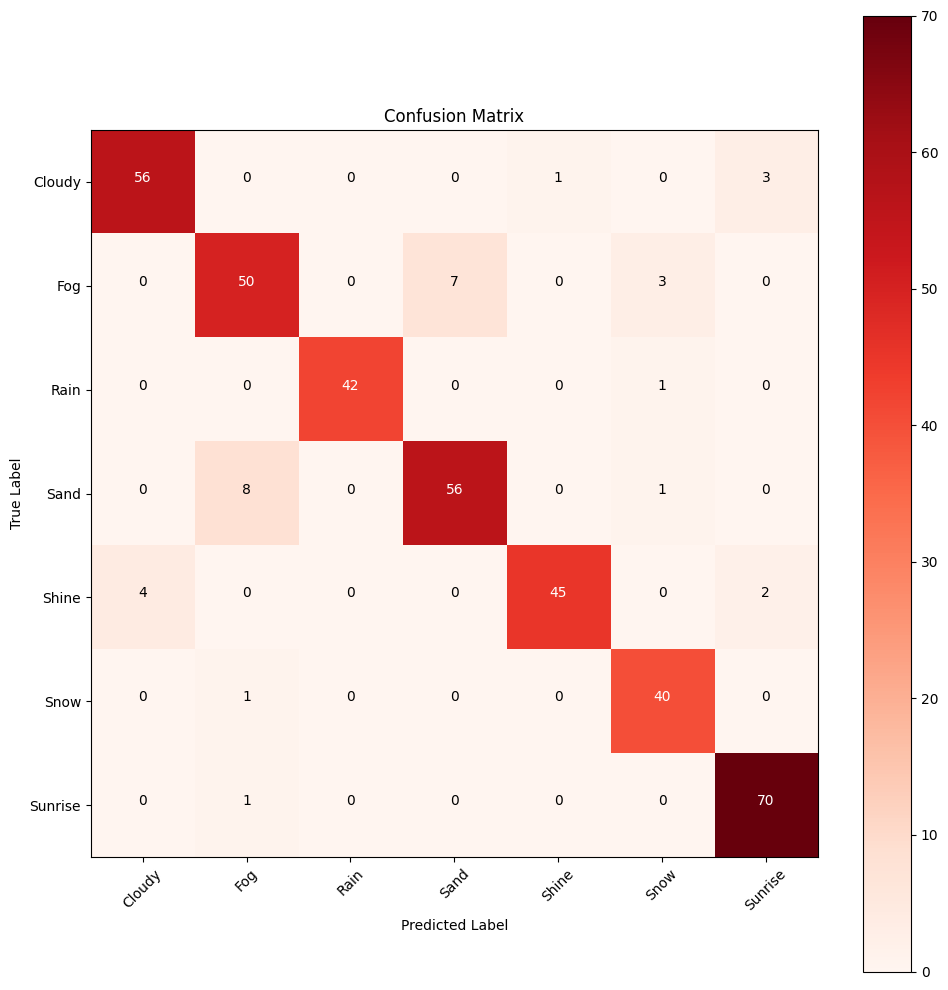

In [ ]:
# Confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

classes = np.unique(y_test)
cm_test = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_test, classes)

In [ ]:
# ROC curve and AUC score
def plot_roc_curve(y_true, y_pred, classes):
    plt.figure(figsize=(10, 8))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true == classes[i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {classes[i]}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

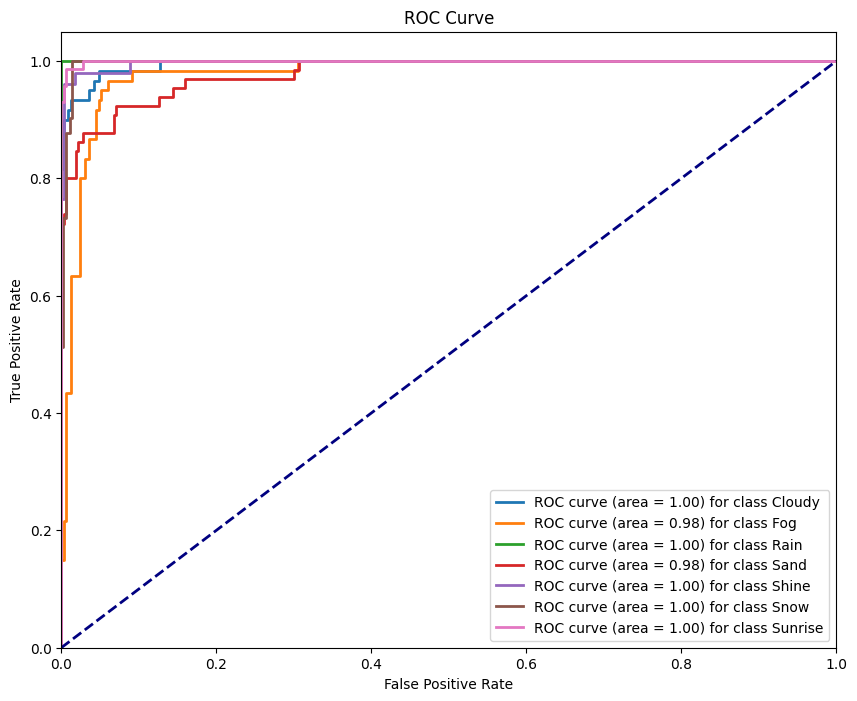

In [ ]:
# Combine predictions into probability scores
y_pred_proba_test = model.predict_proba(X_test_scaled)
plot_roc_curve(y_test, y_pred_proba_test, classes)


In [ ]:
# Calculate model accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Model Test Accuracy: {test_accuracy}")

Model Test Accuracy: 0.9181585677749361
